In [1]:
import yolov5
import requests
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
import torch
torch.backends.nnpack.enabled = False

In [2]:
def download_image(image_link: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = "downloaded_image.jpg"
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename    

In [190]:
# set image
#img = 'https://tablica-rejestracyjna.pl/images/photos/20241222194356.jpeg'
img = "https://tablica-rejestracyjna.pl/images/photos/20241221145937.jpg" 
img = "https://tablica-rejestracyjna.pl/images/photos/20241220211840_1.jpeg"


img = "https://tablica-rejestracyjna.pl/images/photos/20241226000931.png" # 2 tablice
img = 'https://tablica-rejestracyjna.pl/images/photos/20241222132622.jpg' # 2 tablice
img = 'https://tablica-rejestracyjna.pl/images/photos/20241223133614.jpg' # 3 tablice



img_filename = download_image(img)
img = cv2.imread(img_filename)

print(img.shape)


(4032, 3024, 3)


In [191]:
# load model
model = yolov5.load('keremberke/yolov5m-license-plate')
  
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image



# perform inference


# inference with test time augmentation
#results = model(img, augment=True)

# parse results



# show detection bounding boxes on image
#results.show()

# save results into "results/" folder
#results.save(save_dir='results/')


In [192]:
tstart = time.time()
results = model(img, size=640)
print("inference time", time.time() - tstart)

/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


inference time 0.2727549076080322


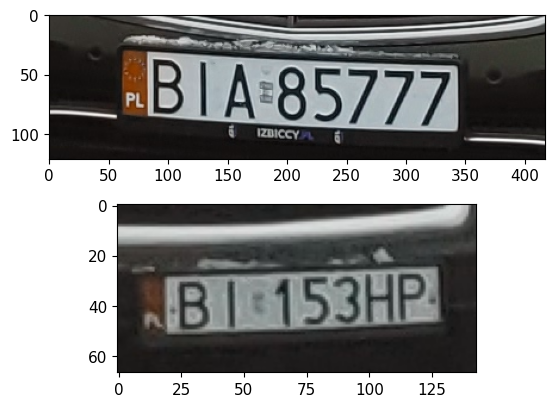

In [193]:
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]
%matplotlib inline
#boxes = np.matrix(boxes)

fig, axs = plt.subplots(len(boxes))

skewed_plates = []

for i, box in enumerate(boxes):
    box = [int(x) for x in box]
    x1, y1, x2, y2 = box
    #print(x1, y1, x2, y2)
    if(x1 > x2):
        x2, x1 = x1, x2
    if(y1 > y2):
        y2, y1 = y1, y2

    w = x2 - x1 
    h = y2 - y1 
    dw = int(0.2 * w)
    dh = int(0.2 * h)


    x2 += dw 
    x1 -= dw

    y2 += dh
    y1 -= dh


    reg = img[y1:y2, x1:x2]

    #kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
    #reg = cv2.filter2D(reg, -1, kernel) 
    

    skewed_plates.append(reg.copy())

    axs[i].imshow(reg)



2


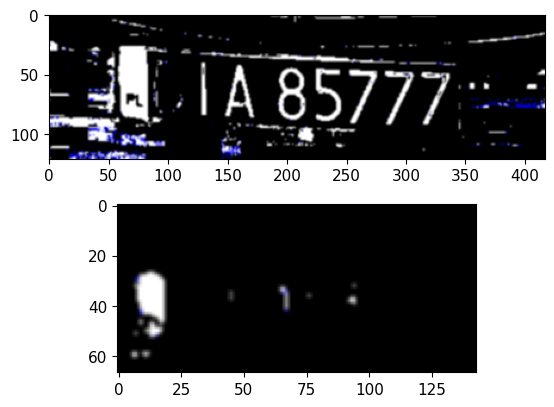

In [198]:

fig, axs = plt.subplots(len(boxes), 1)
print(len(skewed_plates))

enchanced = []

for i, plate in enumerate(skewed_plates):
    plate = plate.copy()
    hsv_image = cv2.cvtColor(plate, cv2.COLOR_BGR2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,1]
    hsv_image[:,:,2] = np.clip(hsv_image[:,:,2], 0, 255)
    hsv_image[:,:,1] = hsv_image[:,:,1]/50
    hsv_image[:,:,0] = 0 #hsv_image[:,:,1]/30
    #hsv_image[:,:,1] = np.clip(hsv_image[:,:,1], 0, 255)

    


    #hsv_image[:, :, 0] = 0  # Set hue to 0

    #hsv_image[:, :, 1] = 0  # Set saturation to 0
    #hsv_image[:, :, 2] = 0  # Set saturation to 0

    # Convert back to BGR
    no_hue_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    ret,no_hue_image = cv2.threshold(no_hue_image, 60, 255, cv2.THRESH_BINARY)
    no_hue_image = cv2.GaussianBlur(no_hue_image,(3,3),0)

    enchanced.append(no_hue_image)


    axs[i].imshow(no_hue_image)

2


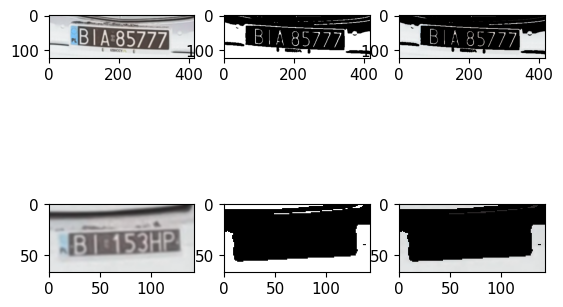

In [199]:

fig, axs = plt.subplots(len(boxes), 3)
print(len(skewed_plates))

enchanced = []

for i, plate in enumerate(skewed_plates):
    plate = plate.copy()
    plate = cv2.GaussianBlur(plate,(5,5),0)
    hsv_image = cv2.cvtColor(plate, cv2.COLOR_BGR2HSV)
    #hsv_image[:,:,2] = hsv_image[:,:,1]
    #hsv_image[:,:,2] = np.clip(hsv_image[:,:,2], 0, 255)
    #hsv_image[:,:,1] = hsv_image[:,:,1]/50


    low = 40
    high = 210
    #low = np.array([0, low, 0])
    #high = np.array([180, high, 255])
    #mask = cv2.medianBlur(plate, 3)

    
    mask = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask = cv2.inRange(mask, low, high)
    mask = cv2.bitwise_not(mask)
    plate = cv2.bitwise_not(plate)
    output = cv2.bitwise_and(plate, plate, mask = mask)

    enchanced.append(output)

    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 2].imshow(output)

2


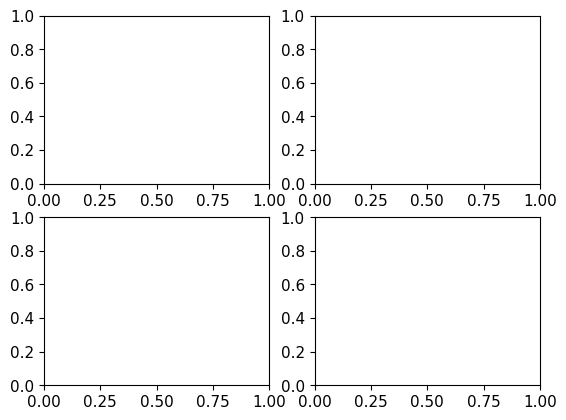

In [196]:

fig, axs = plt.subplots(len(boxes), 2)
print(len(skewed_plates))
for i, plate in enumerate(enchanced):
    
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    

    # Apply edge detection
    edges = cv2.Canny(gray, 230, 255)
    axs[i, 0].imshow(edges)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and pick the largest plausible one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    result = plate.copy()
    
    for j, contour in enumerate(contours):
        cv2.drawContours(result, [contour], -1, (0, 255, 0), 3)
        axs[i, j+1].imshow(result)
        # Approximate the contour to find a quadrilateral
        epsilon = 1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # Check if it's a quadrilateral
            license_plate_contour = approx
            break
            
            
        if(not j < 0):
            break

    #if license_plate_contour is not None:
    #    # Draw the contour for visualization
    #    result = plate.copy()
    #    cv2.drawContours(result, [license_plate_contour], -1, (0, 255, 0), 3)
    #    axs[i].imshow(result)
    #    #cv2.imshow("Detected License Plate", result)

    #_, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #ret, thresh = cv2.threshold(gray, center+20, 255, 0)
    #thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


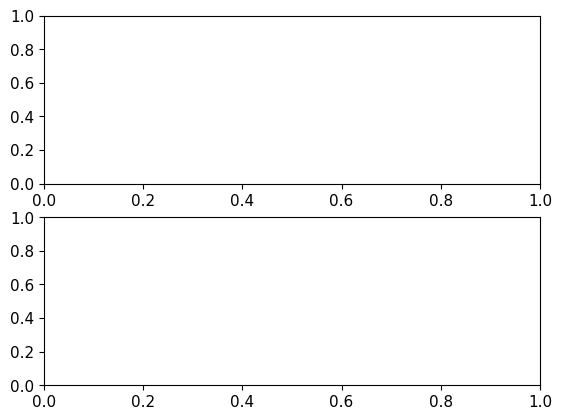

In [197]:
import easyocr
fig, axs = plt.subplots(len(boxes), 1)
reader = easyocr.Reader(['en'])
for i, plate in enumerate(enchanced):
    plate = plate.copy()
    #plate = cv2.GaussianBlur(plate,(7,7),0)
    ocr_result = reader.readtext(plate, detail=0)
    print(ocr_result)
    print("Recognized Text:", ' '.join(ocr_result))
    axs[i].imshow(plate)

In [13]:
import pytesseract # this is tesseract module 
import matplotlib.pyplot as plt 
import cv2 # this is opencv module 
import glob 
import os

In [17]:
for plate in skewed_plates:

    predicted_result = pytesseract.image_to_string(plate, lang ='eng')#, 
    #config ='--oem 3 --psm 6 -c tessedit_char_whitelist = ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789') 
      
    
    print(predicted_result)





2D —S é
> |ADW:4540X,

;

